# Realization of Non-Recursive Filters

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Quantization Effects

Numbers and numerical operations are represented with a finite numerical resolution in digital processors. The same holds for the amplitude values of signals and the algorithmic operations applied to them. Hence, the intended characteristics of a digital filter may deviate in practice due to the finite numerical resolution. The [double-precision floating point representation](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) used in numerical environments like MATLAB or Python/numpy is assumed to be quasi-continuous. This representation serves therefore as reference for the evaluation of quantization effects.

This section investigates the consequences of quantization in non-recursive filters. We first take a look on the quantization of the filter coefficients, followed by the effects caused by a finite numerical resolution of the operations. The realization of non-recursive filters is subject to both effects.

### Quantization of Filter Coefficients

The output signal $y[k]$ of a non-recursive filter with a finite impulse response (FIR) $h[k]$ of length $N$ is given as

\begin{equation}
y[k] = h[k] * x[k] = \sum_{\kappa = 0}^{N-1} h[\kappa] \; x[k - \kappa]
\end{equation}

where $x[k]$ denotes the input signal. The quantized impulse response $h_Q[k]$ (quantized filter coefficients) is yielded by quantizing the impulse response $h[k]$

\begin{equation}
h_Q[k] = \mathcal{Q} \{ h[k] \} = h[k] + e[k]
\end{equation}

where $e[k] = h_Q[k] - h[k]$ denotes the [quantization error](../quantization/introduction.ipynb#Model-of-the-Quantization-Process). Introducing $h_Q[k]$ into above equation and rearranging results in

\begin{equation}
y_Q[k] = \sum_{\kappa = 0}^{N-1} h[\kappa] \; x[k - \kappa] + \sum_{\kappa = 0}^{N-1} e[\kappa] \; x[k - \kappa]
\end{equation}

The input signal $x[k]$ is filtered by the quantization noise $e[k]$ and superimposed to the desired output of the filter. The overall transfer function $H_Q(e^{j \Omega})$ of the filter with quantized filter coefficients is given as

\begin{equation}
H_Q(e^{j \Omega}) = \sum_{k=0}^{N-1} h[k] \; e^{-j \Omega k} + \sum_{k=0}^{N-1} e[k] \; e^{-j \Omega k}  = H(e^{j \Omega}) + E(e^{j \Omega})
\end{equation}

Hence, the quantization of filter coefficients results in a linear distortion of the desired frequency response. To some extent, this distortion can be incorporated into the design of the filter. However, the magnitude of the quantization error $| E(e^{j \Omega}) |$ cannot get arbitrarily small for a finite quantization step $Q$. This limits the achievable attenuation of a digital filter with quantized coefficients. It is therefore important to normalize the filter coefficients $h[k]$ before quantization in order to keep the relative power of the quantization noise small.

#### Example - Effect of coefficient quantization in a lowpass filter

The coefficients of a digital lowpass filter with a cutoff frequency of $\Omega_0 = \frac{\pi}{2}$ are quantized in the following example.

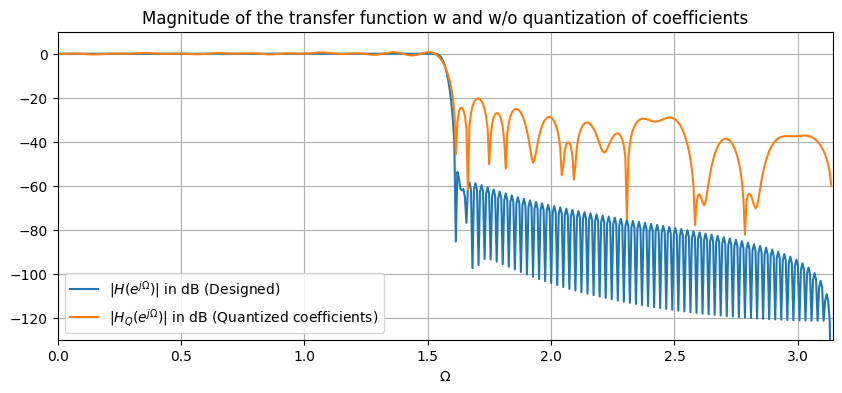

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

w = 8  # wordlength of quantized coefficients
A = 1  # attenuation of filter coefficients
N = 256  # number of coefficients for filter
Q = 1 / (2 ** (w - 1))  # quantization stepsize


def uniform_midtread_quantizer(x, Q):
    """Uniform mid-tread quantizer with limiter."""
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x / Q + 1 / 2)

    return xQ


# design lowpass
h = A * sig.firwin(N, 0.5)
# quantize coefficients
hQ = uniform_midtread_quantizer(h, Q)

# plot frequency response
Om, H = sig.freqz(h)
Om, HQ = sig.freqz(hQ)
Om, E = sig.freqz(hQ - h)

plt.figure(figsize=(10, 4))
plt.plot(Om, 20 * np.log10(np.abs(H)), label=r"$| H(e^{j \Omega}) |$ in dB (Designed)")
plt.plot(
    Om,
    20 * np.log10(np.abs(HQ)),
    label=r"$| H_Q(e^{j \Omega}) |$ in dB (Quantized coefficients)",
)
plt.title("Magnitude of the transfer function w and w/o quantization of coefficients")
plt.xlabel(r"$\Omega$")
plt.axis([0, np.pi, -130, 10])
plt.legend(loc=3)
plt.grid()

**Exercise**

* Change the wordlength `w` of the quantized filter coefficients. How does the magnitude response $| H_Q(e^{j \Omega}) |$ of the quantized filter change?
* Change the attenuation `A` of the filter coefficients. What changes?
* Why does the magnitude response of the quantized filter $| H_Q(e^{j \Omega}) |$ deviate more from the magnitude response of the designed filter $| H(e^{j \Omega}) |$ in the frequency ranges with high attenuation?

Solution: The magnitude response of the quantized filter deviates more from the designed filter the shorter the wordlength `w` is chosen. This is due to the increasing quantization error for shorter wordlengths. The quantization error increases also in comparison to the filter coefficients if their amplitude (attenuation `A`) is small. The deviations from the designed filter are generally higher for high attenuations since the quantization error is additive $H_Q(e^{j \Omega}) = H(e^{j \Omega}) + E(e^{j \Omega})$, as derived above.

### Quantization of Signals and Operations

Besides the quantization of filter coefficients $h[k]$, also the quantization of the signals, state variables and operations has to be considered in a practical implementation of filters. The computation of the output signal $y[k] = h[k] * x[k]$ of a non-recursive filter by convolution involves multiplications and additions. In digital signal processors numbers are often represented in [fixed-point arithmetic](https://en.wikipedia.org/wiki/Fixed-point_arithmetic) using [two's complement](https://en.wikipedia.org/wiki/Two's_complement). When multiplying two numbers with a wordlength of $w$-bits in this representation the result would require $2w$-bits. Hence the result has to be requantized to $w$-bits. The rounding operation in the quantizer is often realized as truncation of the $w$ least significant bits. The resulting quantization error is known as [round-off error](https://en.wikipedia.org/wiki/Round-off_error). The addition of two numbers may fall outside the maximum/minimum values of the representation and may suffer from clipping. Similar considerations hold also for other number representations, like e.g. [floating point](https://en.wikipedia.org/wiki/Floating_point).

As for the [quantization noise](../quantization/linear_uniform_quantization_error.ipynb#Model-for-the-Quantization-Error), a statistical model for the round-off error in multipliers is used to quantify the average impact of round-off noise in a non-recursive filter.

#### Model for round-off errors in multipliers

As outlined above, multipliers require a requantization of the result in order to keep the wordlength constant. The multiplication of a quantized signal $x_Q[k]$ with a quantized factor $a_Q$ can be written as

\begin{equation}
y_Q[k] = \mathcal{Q} \{ a_Q \cdot x_Q[k] \} = a_Q \cdot x_Q[k] + e[k]
\end{equation}

where the round-off error $e[k]$ is defined as

\begin{equation}
e[k] = y_Q[k] - a_Q \cdot x_Q[k]
\end{equation}

This leads to the following model of a multiplier including round-off effects

![Model for round-off noise in a multiplier](roundoff_model.png)

The round-off error can be modeled statistically in the same way as quantization noise [[Zölzer](../index.ipynb#Literature)]. Under the assumption that the average magnitude of $a_Q \cdot x_Q[k]$ is much larger that the quantization step size $Q$, the round-off error $e[k]$ can be approximated by the following statistical model

1. The round-off error $e[k]$ is not correlated with the input signal $x_Q[k]$

2. The round-off error is [white](../random_signals/white_noise.ipynb)

    $$ \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \sigma_e^2 $$

2. The probability density function (PDF) of the round-off error is given by the zero-mean [uniform distribution](../random_signals/important_distributions.ipynb#Uniform-Distribution)

    $$ p_e(\theta) = \frac{1}{Q} \cdot \text{rect} \left( \frac{\theta}{Q} \right) $$

The variance (power) of the round-off error is [derived from its PDF](../random_signals/important_distributions.ipynb#Uniform-Distribution) as

\begin{equation}
\sigma_e^2 = \frac{Q^2}{12}
\end{equation}

#### Round-off noise

Using above model of a multiplier and discarding clipping, a straightforward realization of the convolution with quantized signals would be to requantize after every multiplication 

\begin{equation}
\begin{split}
y_Q[k] &= \sum_{\kappa = 0}^{N-1} \mathcal{Q} \{ h_Q[\kappa] \; x_Q[k - \kappa] \} \\
&= \sum_{\kappa = 0}^{N-1} h_Q[\kappa] \; x_Q[k - \kappa] + e[\kappa] \\ 
&= \left( \sum_{\kappa = 0}^{N-1} h_Q[\kappa] \; x_Q[k - \kappa] \right) + e_\text{tot}[k]
\end{split}
\end{equation}

where $e_\text{tot}[k] = \sum_{\kappa = 0}^{N-1} e[\kappa]$. The round-off errors $e[\kappa]$ for each multiplication are uncorrelated to each other. The overall power of the round-off error is then given as

\begin{equation}
\sigma_{e, \text{tot}}^2 = N \cdot \frac{Q^2}{12}
\end{equation}

Many digital signal processors allow to perform the multiplications and additions in an internal register with double wordlength. In this case, only the result of the convolution sum has to be requantized 

\begin{equation}
y_Q[k] = \mathcal{Q} \left\{ \sum_{\kappa = 0}^{N-1}  h_Q[\kappa] \; x_Q[k - \kappa] \right\} = 
\left( \sum_{\kappa = 0}^{N-1} h_Q[\kappa] \; x_Q[k - \kappa] \right) + e[k]
\end{equation}

and the total power of the round-off noise in this case is

\begin{equation}
\sigma_{e, \text{tot}}^2 = \frac{Q^2}{12}
\end{equation}

It is evident that this realization is favorable due to the lower round-off noise, especially for filters with a large number $N$ of coefficients.

#### Example - Effect of requantization after each multiplication

The following example simulates the round-off noise of a non-recursive filter when requantization is performed after each multiplication. Clipping is not considered. The input signal $x[k]$ is drawn from a [uniform distribution](../random_signals/important_distributions.ipynb#Uniform-Distribution) with $a=-1$ and $b=1-Q$. Both the input signal and filter coefficients are quantized. The output signal $y[k]$ without requantization of the multiplications is computed, as well as the output signal $y_Q[k]$ with requantization. The statistical properties of the round-off noise $e[k] = y_Q[k] - y[k]$ are evaluated.

Power of overall round-off noise is -86.069726 dB


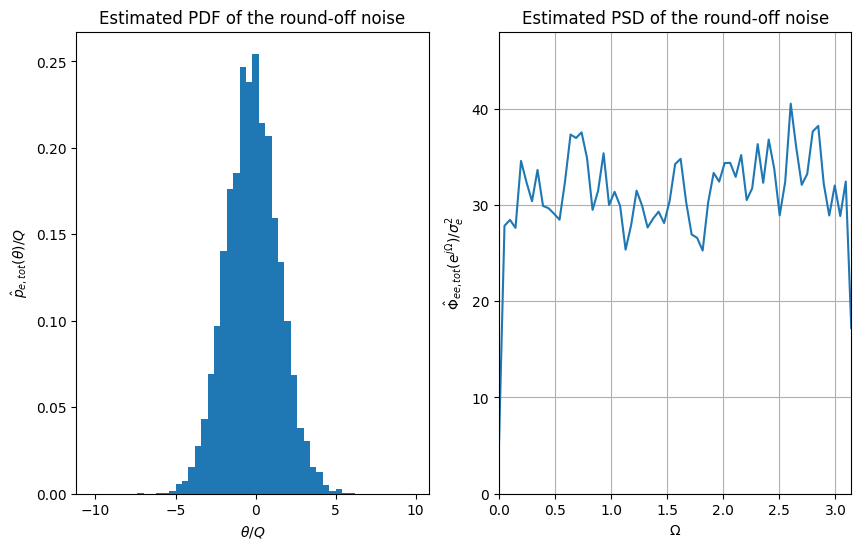

In [2]:
w = 16  # wordlength of quantized coefficients/operations
N = 32  # number of coefficients for filter
L = 8192  # length of input signal
Q = 1 / (2 ** (w - 1))  # quantization stepsize


def uniform_midtread_quantizer(x, Q):
    """Uniform mid-tread quantizer."""
    xQ = Q * np.floor(x / Q + 1 / 2)

    return xQ


# random impulse response
h = np.random.uniform(size=N, low=-1, high=1)
hQ = uniform_midtread_quantizer(h, Q)
# input signal
x = np.random.uniform(size=L, low=-1, high=1 - Q)
xQ = uniform_midtread_quantizer(x, Q)
# output signal by convolution
y = np.zeros(L + N - 1)
yQ = np.zeros(L + N - 1)
for k in np.arange(L):
    for kappa in np.arange(N):
        if (k - kappa) >= 0:
            y[k] += hQ[kappa] * xQ[k - kappa]
            yQ[k] += uniform_midtread_quantizer(hQ[kappa] * xQ[k - kappa], Q)

# overall round-off error
e = yQ - y

# estimate power of round-off error
sx = 10 * np.log10(np.var(e))
print("Power of overall round-off noise is %f dB" % sx)
# estimated PDF of round-off error
pe, bins = np.histogram(e, bins=50, density=True, range=(-10 * Q, 10 * Q))
# estimate PSD of round-off error
nf, Pee = sig.welch(e, nperseg=128)


# plot statistical properties of error signal
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.bar(bins[:-1] / Q, pe * Q, width=20 / len(pe))
plt.title("Estimated PDF of the round-off noise")
plt.xlabel(r"$\theta / Q$")
plt.ylabel(r"$\hat{p}_{e,tot}(\theta) / Q$")
# plt.axis([-1, 1, 0, 1.2])

plt.subplot(122)
plt.plot(nf * 2 * np.pi, Pee * 6 / Q**2)
plt.title("Estimated PSD of the round-off noise")
plt.xlabel(r"$\Omega$")
plt.ylabel(r"$\hat{\Phi}_{ee,tot}(e^{j \Omega}) / \sigma_e^2$")
plt.axis([0, np.pi, 0, 1.5*N ])
plt.grid()

**Exercise**

* Change the wordlength `w` and check if the $\sigma_{e,tot}^2$ derived by numerical simulation is equal to its theoretic value derived above?
* Can you explain the shape of the estimated PDF for the round-off noise?

Solution: The power of the overall round-off noise was derived above as $\sigma_{e,tot}^2 = N \frac{Q}{12}$. Using results from the [model of quantization noise for a uniform quantizer](../quantization/linear_uniform_quantization_error.ipynb#Model-for-the-Quantization-Error) this can be rewritten as $10 \log_{10} (\sigma_{e,tot}^2) \approx 10 \log_{10} (N) - 10 \log_{10} (3) - 6.02 w$. Hence a doubling of the filter length results in approximately 3 dB more round-off noise at the filter output. The requantization noise of the individual multiplications can be modeled as uniformly distributed white noise. It follows from the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) that the superposition of these individual round-off errors results in a normal distribution.

#### Example - Comparison of round-off noise of conventional and fast convolution

The overall round-off noise in an FIR filter scales with the number of multiplications when rounding is performed after each of these. The fast convolution algorithm requires less multiplications and as a consequence also less rounding operations resulting in potentially less round-off noise at the filter output. This effect is illustrated by the following example. The conventional convolution and the fast convolution is computed for two rectangular signals of the same length $y[k] = A\cdot\text{rect}_L[k] * A\cdot\text{rect}_L[k]$. The round-off noise is computed by comparing the results to the theoretical result $A^2 L \cdot \Lambda_{2L -1}[k]$. Since we cannot change the representation of numbers nor the rounding operations in the given implementation of the FFT, a floating point representation of the signal amplitudes is used for this example. The amplitude $A$ has been chosen such to trigger rounding operations.

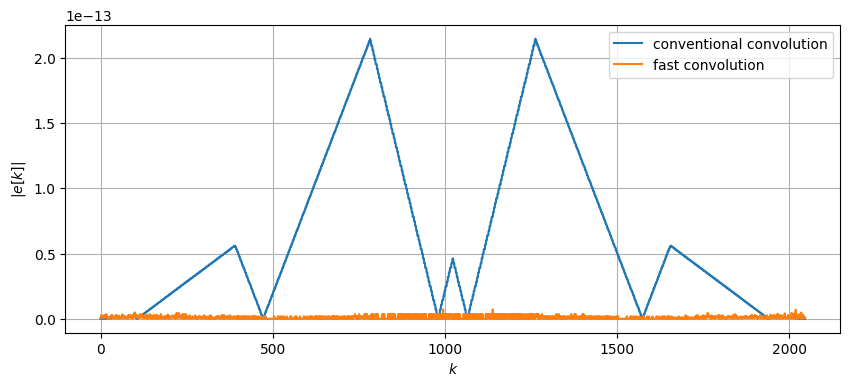

In [3]:
L = 1024  # length of signals x[k]
A = 1 / 7  # amplitude of signal
M = 2 * L - 1


# generate signals
x = A * np.ones(L)
y = A**2 * L * sig.windows.triang(M)

# linear convolution
y1 = np.convolve(x, x, "full")
e1 = y - y1
# fast convolution
y2 = np.fft.irfft(np.fft.rfft(x, M + 1) * np.fft.rfft(x, M + 1))[0:M]
e2 = y - y2

plt.figure(figsize=(10, 4))
plt.plot(np.abs(e1), label="conventional convolution")
plt.plot(np.abs(e2), label="fast convolution")
plt.xlabel(r"$k$")
plt.ylabel(r"$|e[k]|$")
plt.legend()
plt.grid()

**Exercises**

* Change the length `L` of the signal. How does the round-off noise scale with length? Why?
* Extend above code to compute the power of the round-off noise for various lengths.

Solution: The round-off noise scales with the number of multiplications which itself scales by the length `L` of the signal. To some extend this also explains the shape of the round-off errors for the conventional convolution. The two rectangular functions overlap fully in the center which results in the maximum number of non-zero multiplications.

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples*.